# PROJET 2 - PREVISION DES BESOINS EN INFRASTRUCTURES SCOLAIRES PAR COMMUNE A ABIDJAN

### Import des packages

In [1]:
import pandas as pd
import geopandas as gpd
import ee
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geemap

In [70]:
import numpy as np

In [2]:
import shapely
from shapely.geometry import Point, Polygon
import requests
import json


In [3]:
import os

### EARTH ENGINE

### Authentification

In [4]:
"""
import ee

ee.Authenticate()
"""

'\nimport ee\n\nee.Authenticate()\n'

### Initialisation de Google Earth Engine

In [5]:
ee.Initialize()

In [6]:
"""
dossiers = ['data/donnees_brutes', 'data/donnees_propres', 'outputs/cartes', 'outputs/analyses']

for d in dossiers:
    if not os.path.exists(d):
        os.makedirs(d, exist_ok=True)
        print(f"Dossier créé : {d}")
"""

'\ndossiers = [\'data/donnees_brutes\', \'data/donnees_propres\', \'outputs/cartes\', \'outputs/analyses\']\n\nfor d in dossiers:\n    if not os.path.exists(d):\n        os.makedirs(d, exist_ok=True)\n        print(f"Dossier créé : {d}")\n'

## CHARGEMENT DES COMMUNES

Pour éviter les erreurs de connexion non sécurisée, on met à jour les certificats de sécurité de l'environnement python.

In [7]:
import os
import certifi

os.environ['SSL_CERT_FILE'] = certifi.where()

On récupère les frontières géographiques des 13 communes d'Abidjan depuis OpenStreetMap, afin de définir le champ d'étude qui représente ici la commune

In [8]:
import osmnx as ox
admin_districts = ox.features_from_place("Abidjan, Côte d'Ivoire", tags={"admin_level": "8"})
admin_districts = admin_districts[['name', 'geometry']]
print(f"Nombre de communes récupérées : {len(admin_districts)}")

Nombre de communes récupérées : 57


On définit notre jeu de données comprenant les communes récupérées.

In [9]:
# Vérifier la liste des communes récupérées
print(admin_districts['name'].unique())

# Filtrer pour ne garder que les communes principales du District si nécessaire
communes_interet = [
    "Abobo", "Adjamé", "Attécoubé", "Cocody", "Koumassi", 
    "Marcory", "Plateau", "Port-Bouët", "Treichville", "Yopougon", 
    "Anyama", "Bingerville", "Songon"
]
df_abidjan = admin_districts[admin_districts['name'].isin(communes_interet)]

['Cocody' 'Treichville' 'Le Plateau' 'Marcory' 'Koumassi' 'Attécoubé'
 'Adjamé' 'Port-Bouët' 'Yopougon' 'Abobo' 'Commune de Grand-Bassam' nan]


Cependant, il manque Anyama, Bingerville et Songon. Donc on force la recherche individuelle pour ces communes. Et on ajoute les communes manquantes au jeu de données.

In [10]:
import osmnx as ox
import pandas as pd
import urllib3

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

ox.settings.requests_kwargs = {'verify': False}

communes_noms = ["Anyama", "Bingerville", "Songon"]
gdfs_manquants = []

for nom in communes_noms:
    try:
        query = f"{nom}, District Autonome d'Abidjan, Côte d'Ivoire"
        gdf = ox.geocode_to_gdf(query)
        gdf['name'] = nom
        gdfs_manquants.append(gdf)
        print(f"Succès pour {nom}")
    except Exception as e:
        print(f"Échec pour {nom} : {e}")

# Fusion 
if gdfs_manquants:
    df_manquants = pd.concat(gdfs_manquants, ignore_index=True)
    df_abidjan_complet = pd.concat([df_abidjan, df_manquants], ignore_index=True)
    df_abidjan_complet = df_abidjan_complet.drop_duplicates(subset=['name'])
else:
    df_abidjan_complet = df_abidjan

print(f"Total communes : {len(df_abidjan_complet)}")
print(df_abidjan_complet['name'].tolist())

Succès pour Anyama
Succès pour Bingerville
Succès pour Songon
Total communes : 12
['Cocody', 'Treichville', 'Marcory', 'Koumassi', 'Attécoubé', 'Adjamé', 'Port-Bouët', 'Yopougon', 'Abobo', 'Anyama', 'Bingerville', 'Songon']


Il manque Le Plateau, donc on force la recherche individuelle pour cette commune. Et on ajoute la commune manquante au jeu de données.

In [11]:
try:
    # On tente de récupérer "Le Plateau" spécifiquement
    gdf_plateau = ox.geocode_to_gdf("Le Plateau, Abidjan, Côte d'Ivoire")
    gdf_plateau['name'] = "Plateau" # On harmonise le nom
    
    # On l'ajoute à ton GeoDataFrame complet
    df_abidjan_complet = pd.concat([df_abidjan_complet, gdf_plateau], ignore_index=True)
    
    # Nettoyage final des doublons au cas où
    df_abidjan_complet = df_abidjan_complet.drop_duplicates(subset=['name'])
    
    print(f"Succès ! Le Plateau a été ajouté. Total : {len(df_abidjan_complet)} communes.")
    print(df_abidjan_complet['name'].tolist())
except Exception as e:
    print(f"Erreur pour Le Plateau : {e}")

Succès ! Le Plateau a été ajouté. Total : 13 communes.
['Cocody', 'Treichville', 'Marcory', 'Koumassi', 'Attécoubé', 'Adjamé', 'Port-Bouët', 'Yopougon', 'Abobo', 'Anyama', 'Bingerville', 'Songon', 'Plateau']


In [12]:
df_abidjan_complet.head(13)

,name,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,display_name
0,Cocody,POINT (-3.99493 5.35737),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Treichville,"POLYGON ((-4.03362 5.30429, -4.02226 5.31133, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Marcory,"POLYGON ((-4.00415 5.31786, -3.99241 5.32272, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Koumassi,"POLYGON ((-3.96459 5.27353, -3.96493 5.27412, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Attécoubé,"POLYGON ((-4.08424 5.40104, -4.08417 5.40162, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Adjamé,"POLYGON ((-4.0332 5.35396, -4.03314 5.35423, -...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Port-Bouët,"POLYGON ((-4.03424 5.2427, -4.03245 5.26563, -...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Yopougon,"POLYGON ((-4.13315 5.39754, -4.08424 5.40104, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Abobo,"POLYGON ((-4.17131 5.44957, -4.1611 5.45117, -...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Anyama,"POLYGON ((-4.27334 5.44522, -4.27332 5.44516, ...",-4.273340,5.374660,-3.813537,5.636327,408626030.0,relation,3377941.0,5.496054,-4.051241,boundary,administrative,14.0,0.372212,city,"Anyama, Abidjan, Côte d'Ivoire"


Le jeu de données est maintenant complet.

On génère ensuite une carte statique des communes récupérées et on place automatiquement le nom de chaque commune en son centre

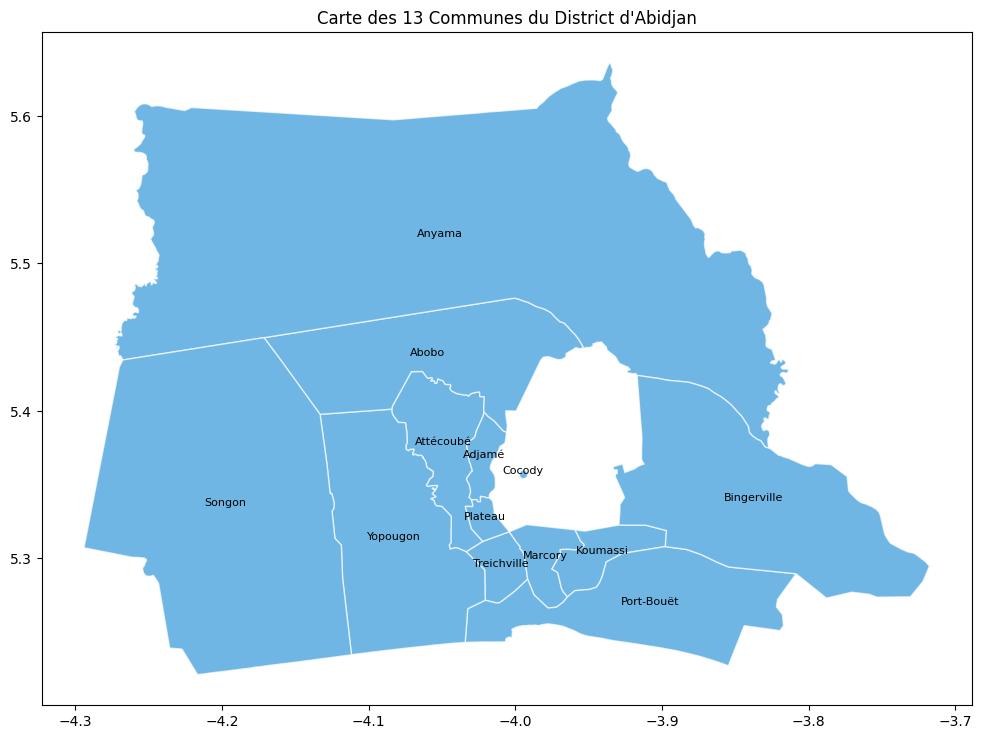

In [13]:
import matplotlib.pyplot as plt

ax = df_abidjan_complet.plot(figsize=(12, 10), edgecolor='white', color='#3498db', alpha=0.7)
df_abidjan_complet.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=8), axis=1)

plt.title("Carte des 13 Communes du District d'Abidjan")
plt.show()

## RECUPERATION DES ECOLES EXISTANTES A ABIDJAN

### Fonction de récupération des écoles

Avec cette fonction, on interroge l'API Overpass, le moteur de recherche de données géographiques OpenStreetMap, pour extraire tous les points cartographiés comme étant des écoles dans la zone d'Abidjan.

In [14]:
import requests

def recup_ecoles_osm(region="Abidjan"):
    query = f"""
    [out:json][timeout:180];
    area["name"="{region}"]->.searchArea;
    (
      node["amenity"="school"](area.searchArea);
      node["amenity"="kindergarten"](area.searchArea);
      node["amenity"="college"](area.searchArea);
      way["amenity"="school"](area.searchArea);
      way["amenity"="kindergarten"](area.searchArea);
      way["building"="school"](area.searchArea);
    );
    out center tags;
    """

    url = "https://overpass-api.de/api/interpreter"
    response = requests.get(url, params={'data': query})

    if response.status_code != 200:
        print(f"❌ Erreur HTTP: {response.status_code}")
        return []

    data = response.json()
    elements = data.get("elements", [])

    print(f"✅ {len(elements)} infrastructures scolaires détectées")

    ecoles_traitees = []

    for elem in elements:
        tags = elem.get("tags", {})

        # Gestion coordonnées (node vs way)
        if elem["type"] == "node":
            lat = elem.get("lat")
            lon = elem.get("lon")
        else:
            center = elem.get("center", {})
            lat = center.get("lat")
            lon = center.get("lon")

        if lat is None or lon is None:
            continue

        ecole = {
            "id_osm": elem.get("id"),
            "nom": tags.get("name", "École sans nom"),
            "latitude": lat,
            "longitude": lon,
            "type": tags.get("amenity", tags.get("building", "school")),
            "operator": tags.get("operator", "Inconnu"),
            "capacity": tags.get("capacity"),
            "levels": tags.get("levels"),
            "source": "OpenStreetMap"
        }

        ecoles_traitees.append(ecole)

    return ecoles_traitees


### Récupération réelle des écoles depuis l'API

On récupère les données grâce à la fonction définie précédemment, on les transforme ensuite en un dataframe et on les stocke dans un fichier csv, après avoir relevé les informations statistiques sur ces données.

In [15]:
liste_ecoles = recup_ecoles_osm("Abidjan")

if liste_ecoles:
    print(f"On a :{len(liste_ecoles)} écoles récupérées avec succès")
    
    donnees_ecoles = pd.DataFrame(liste_ecoles)

    print(donnees_ecoles.describe())
    print(f"Nombre de noms non nuls: {donnees_ecoles['nom'].notna().sum()}")
    print(f"Opérateur public: {(donnees_ecoles['operator'] == 'Public').sum()}")
    print(f"Opérateur privé: {(donnees_ecoles['operator'] != 'Public') & (donnees_ecoles['operator'].notna()).sum()}")
    print(donnees_ecoles[['nom', 'latitude', 'longitude', 'operator']].head())
    chemindb = "data/donnees_brutes/ecoles_abidjan.csv"

    donnees_ecoles.to_csv(chemindb, index=False, encoding='utf-8')
    print(f"Données sauvegardées dans {chemindb}")

else:
    print("Aucune école récupérée")
    

❌ Erreur HTTP: 504
Aucune école récupérée


### CREATION DE LA CARTE INTERACTIVE AFIN DE VISUALISER LES ECOLES RECUPEREES

On crée une carte interactive centrée sur Abidjan où chaque école est représentée par un marqueur. 

In [16]:
if 'donnees_ecoles' in locals() and len(donnees_ecoles) > 0:
    print("Données des écoles disponibles")
    print(f"Nombre d'écoles: {len(donnees_ecoles)}")
    print(f"Colonnes: {list(donnees_ecoles.columns)}")
    
    centre_lat = donnees_ecoles['latitude'].mean()
    centre_lng = donnees_ecoles['longitude'].mean()
    centre_abidjan = [centre_lat, centre_lng]

    print(f"Centre de la carte: [{centre_lat}, {centre_lng}]")

    carte_ecoles = folium.Map(location = centre_abidjan, zoom_start=12, tiles='CartoDB positron')

    title_html = '''
    <h3 align="center" style="font-size:16px"><b>Carte des écoles d'Abidjan (OpenStreetMap)</b></h3>
    '''
    carte_ecoles.get_root().html.add_child(folium.Element(title_html))

    ecoles_ajoutees = 0

    for idx, ligne in donnees_ecoles.iterrows():
        if pd.notna(ligne['latitude']) and pd.notna(ligne['longitude']):
            couleur = 'blue'
            if 'public' in str(ligne['operator']).lower():
                couleur = 'green'
            elif 'private' in str(ligne['operator']).lower():
                couleur = 'red'
            
            popup_text = f"{ligne['nom']}<br>Type: {ligne['type']}<br>Opérateur: {ligne['operator']}<br>Capacité:{ligne['capacity']}<br>Niveaux:{ligne['levels']}"

            folium.Marker(
                location=[ligne['latitude'], ligne['longitude']],
                popup=folium.Popup(popup_text, max_width=300),
                icon=folium.Icon(color=couleur, icon='graduation-cap', prefix='fa'),
                tooltip=ligne['nom']
            ).add_to(carte_ecoles)
            
            ecoles_ajoutees += 1

            if ecoles_ajoutees % 100 == 0:
                print(f"Nombre de marqueurs ajoutés: {ecoles_ajoutees}")
    print(f"On a eu {ecoles_ajoutees} écoles ajoutées à la carte")

    legend_html = '''
        <div style="position: fixed; 
                    bottom: 50px; left: 50px; width: 150px; height: 120px; 
                    background-color: white; border:2px solid grey; z-index:9999; 
                    font-size:14px; padding: 10px;">
            <p><i class="fa fa-map-marker" style="color:green"></i> Public</p>
            <p><i class="fa fa-map-marker" style="color:red"></i> Privé</p>
            <p><i class="fa fa-map-marker" style="color:blue"></i> Autre</p>
            </div>
            '''.format(total=len(donnees_ecoles))

    carte_ecoles.get_root().html.add_child(folium.Element(legend_html))

    chemin_carte = "outputs/cartes/cartes_ecoles_abidjan.html"
    carte_ecoles.save(chemin_carte)
    print(f"Carte sauvegardée sous : {chemin_carte}")

    display(carte_ecoles)
else:
    print("Aucune donnée d'école disponible pour générer la carte.")

Aucune donnée d'école disponible pour générer la carte.


### OBTENIR LES ECOLES PAR COMMUNE

Chargement et transformation en geodataframe 

In [17]:
df_ecoles = pd.read_csv('data/donnees_brutes/ecoles_abidjan.csv')

Créer la colonne géométrique : on transforme les colonnes lat et lon en objets mathématiques Point.

In [18]:
geometry = [Point(xy) for xy in zip(df_ecoles.longitude, df_ecoles.latitude)]

On transforme le tableau des écoles en tableau géographique (GeoPandas) et on définit le système de coordonnées officiel (CRS) sur EPSG:4326 (le standard mondial GPS).

In [19]:
ecoles = gpd.GeoDataFrame(df_ecoles, geometry=geometry, crs="EPSG:4326")

Jointure spatiale : la couche des points (écoles) est croisée mathématiquement avec la couche des polygones (communes), tout en vérifiant que chaque écoole est bien située dans une commune.

In [20]:
ecoles_commune = gpd.sjoin(ecoles, df_abidjan_complet, predicate='within')

Compter le nombre d'écoles par commune : on regroupe toutes les écoles par commune et on compte le nombre d'écoles dans chaque commune.

In [21]:
nb_ecoles_par_commune = ecoles_commune.groupby('name').size().reset_index(name='nb_ecoles')

In [22]:
nb_ecoles_par_commune.head(13)

,name,nb_ecoles
0,Abobo,354
1,Adjamé,57
2,Anyama,13
3,Attécoubé,30
4,Bingerville,31
5,Koumassi,85
6,Marcory,50
7,Plateau,22
8,Port-Bouët,49
9,Songon,8


On fusionne la carte des communes avec le tableau du comptage d'écoles. Et si une commune n'a pas d'école, on lui affecte un comptage de 0.

In [23]:
df_ec = df_abidjan_complet.merge(nb_ecoles_par_commune, on='name', how='left').fillna({'nb_ecoles': 0})

In [24]:
print(df_ec[['name', 'nb_ecoles']].sort_values(by='nb_ecoles', ascending=False).head())

       name  nb_ecoles
7  Yopougon      397.0
8     Abobo      354.0
3  Koumassi       85.0
5    Adjamé       57.0
2   Marcory       50.0


On a donc dans notre dataframe, pour chaque commune, le nombre d'écoles.

## POPULATION PAR COMMUNE

On veut intégrer des données démographiques dans notre dataframe. 

On crée manuellemnt un référentiel de population basé sur le dernier Recensement Général de la Population (RGPH 2021) et on le joint à notre dataframe.

Avec cela, on analysera mieux le rapport nombre d'ecoles / population.

In [25]:
data_rgph = {
    'name': [
        'Abobo', 'Adjamé', 'Attécoubé', 'Cocody', 'Koumassi', 'Marcory', 
        'Plateau', 'Port-Bouët', 'Treichville', 'Yopougon', 'Anyama', 'Bingerville', 'Songon'
    ],
    'pop_2021': [
        1340083, 372939, 311602, 630919, 412204, 274838, 
        7148, 515519, 106552, 1571065, 246582, 306236, 112170
    ]
}

df_rgph = pd.DataFrame(data_rgph)

df_ecp = df_ec.merge(df_rgph, on='name', how='left')

In [26]:
df_ecp.head()

,name,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,display_name,nb_ecoles,pop_2021
0,Cocody,POINT (-3.99493 5.35737),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,630919
1,Treichville,"POLYGON ((-4.03362 5.30429, -4.02226 5.31133, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,106552
2,Marcory,"POLYGON ((-4.00415 5.31786, -3.99241 5.32272, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,274838
3,Koumassi,"POLYGON ((-3.96459 5.27353, -3.96493 5.27412, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0,412204
4,Attécoubé,"POLYGON ((-4.08424 5.40104, -4.08417 5.40162, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,311602


In [27]:
df_ecp.columns

Index(['name', 'geometry', 'bbox_west', 'bbox_south', 'bbox_east',
       'bbox_north', 'place_id', 'osm_type', 'osm_id', 'lat', 'lon', 'class',
       'type', 'place_rank', 'importance', 'addresstype', 'display_name',
       'nb_ecoles', 'pop_2021'],
      dtype='object')

## VISUALISATION

Feature Engineering : On crée nos métriques de décision.

1- Calcul de la surface réelle de chaque commune en km2

2- Calcul de la densité de population

3- Calcul de la capacité d'accueil théorique actuelle

In [28]:
# 1
df_ecp['area_km2'] = df_ecp.geometry.to_crs(epsg=3857).area / 10**6

# 2
df_ecp['densite_pop'] = df_ecp['pop_2021'] / df_ecp['area_km2']

# 3
df_ecp['capacite_actuelle'] = df_ecp['nb_ecoles'] * 600

On réalise une segmentation de la population scolaire en fonction de l'âge des élèves.

En Côte d'Ivoire, environ 42% de la population a moins de 15 ans. En étendant ce pourcentage jusqu'à 18 ans, on peut estimer que 48% à 50% de la population est scolaire.

On va donc segmenter la population en 3 groupes :

- Les élèves de 3 ans à 5 ans : 7 à 8%
- Les élèves de 6 ans à 11 ans: 18 à 20%
- Les élèves de 12 ans à 18 ans: 17 à 18%

Mais, pour cette étude, il vaut utiliser une appoche prudente. On prend en compte le fait que 100% des enfants ne sont pas scolarisés, ou certains peuvent être scolarisés en dehors du district.
Donc on reste à 35% pour notre calcul.

In [29]:
df_ecp['pop_scolaire_3_18'] = (df_ecp['pop_2021'] * 0.35).astype(int)

# Segmentation
df_ecp['pop_maternelle'] = (df_ecp['pop_2021'] * 0.07).astype(int) # 3-5 ans
df_ecp['pop_primaire'] = (df_ecp['pop_2021'] * 0.14).astype(int)   # 6-11 ans
df_ecp['pop_secondaire'] = (df_ecp['pop_2021'] * 0.14).astype(int) # 12-18 ans

On calcule ensuite le taux de couverture, c'est-à-dire le pourcentage de la population scolaire qui peut être effectivement accueillie dans les structures scolaires existantes.

In [30]:
# 4
df_ecp['taux_couverture'] = (df_ecp['capacite_actuelle'] / df_ecp['pop_scolaire_3_18']) * 100

In [31]:
# 5
df_ecp['ratio_ecoles_1000_enfants'] = df_ecp['nb_ecoles'] / df_ecp['pop_2021'] * 1000

In [32]:
df_ecp.head()

,name,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,...,pop_2021,area_km2,densite_pop,capacite_actuelle,pop_scolaire_3_18,pop_maternelle,pop_primaire,pop_secondaire,taux_couverture,ratio_ecoles_1000_enfants
0,Cocody,POINT (-3.99493 5.35737),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,630919,0.000000,inf,0.0,220821,44164,88328,88328,0.000000,0.000000
1,Treichville,"POLYGON ((-4.03362 5.30429, -4.02226 5.31133, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,106552,14.973330,7.116119e+03,19200.0,37293,7458,14917,14917,51.484193,0.300323
2,Marcory,"POLYGON ((-4.00415 5.31786, -3.99241 5.32272, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,274838,18.128953,1.516017e+04,30000.0,96193,19238,38477,38477,31.187301,0.181925
3,Koumassi,"POLYGON ((-3.96459 5.27353, -3.96493 5.27412, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,412204,22.610942,1.823029e+04,51000.0,144271,28854,57708,57708,35.350140,0.206209
4,Attécoubé,"POLYGON ((-4.08424 5.40104, -4.08417 5.40162, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,311602,48.487175,6.426483e+03,18000.0,109060,21812,43624,43624,16.504676,0.096277


Graphique du taux de couverture scolaire pour identifier les communes à prioriser

C:\Users\olake\AppData\Local\Temp\ipykernel_20632\3950410211.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


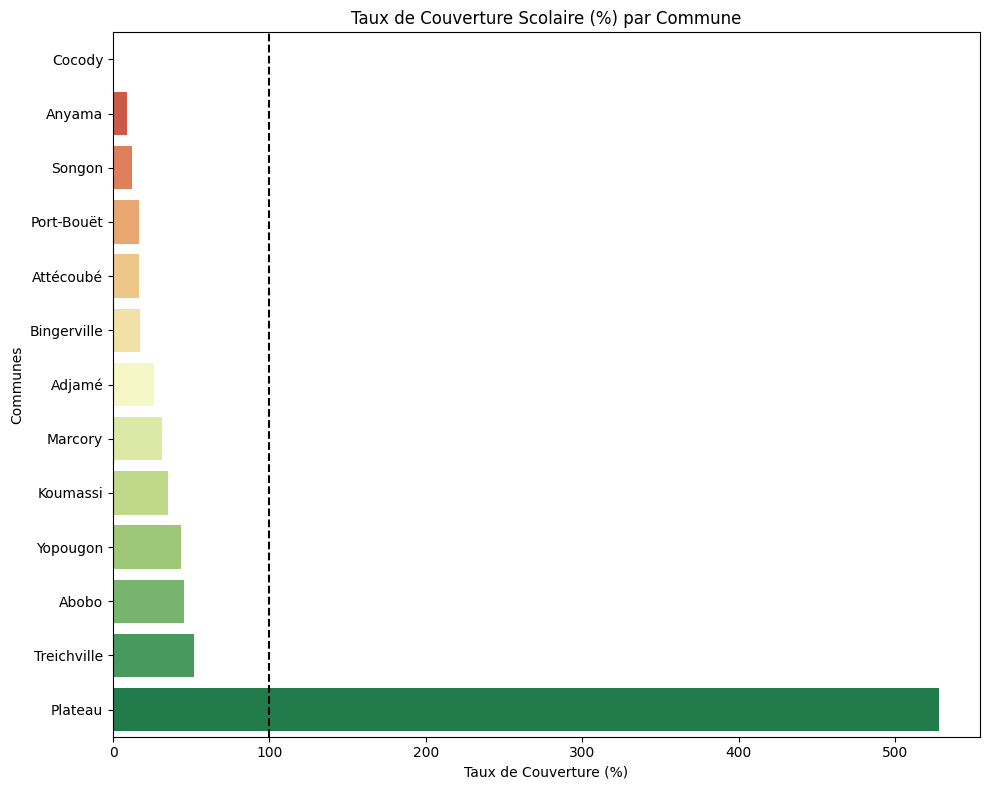

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# On définit simplement la taille de la figure
plt.figure(figsize=(10, 8))

# On lance le barplot directement
sns.barplot(
    data=df_ecp.sort_values('taux_couverture'), 
    x='taux_couverture', 
    y='name', 
    palette='RdYlGn'
)

# On ajoute la ligne verticale et le titre avec plt
plt.axvline(100, color='black', linestyle='--') # Seuil de couverture totale
plt.title('Taux de Couverture Scolaire (%) par Commune')
plt.xlabel('Taux de Couverture (%)')
plt.ylabel('Communes')

plt.tight_layout()
plt.show()

Carte de représentation du déficit de capacité d'accueil

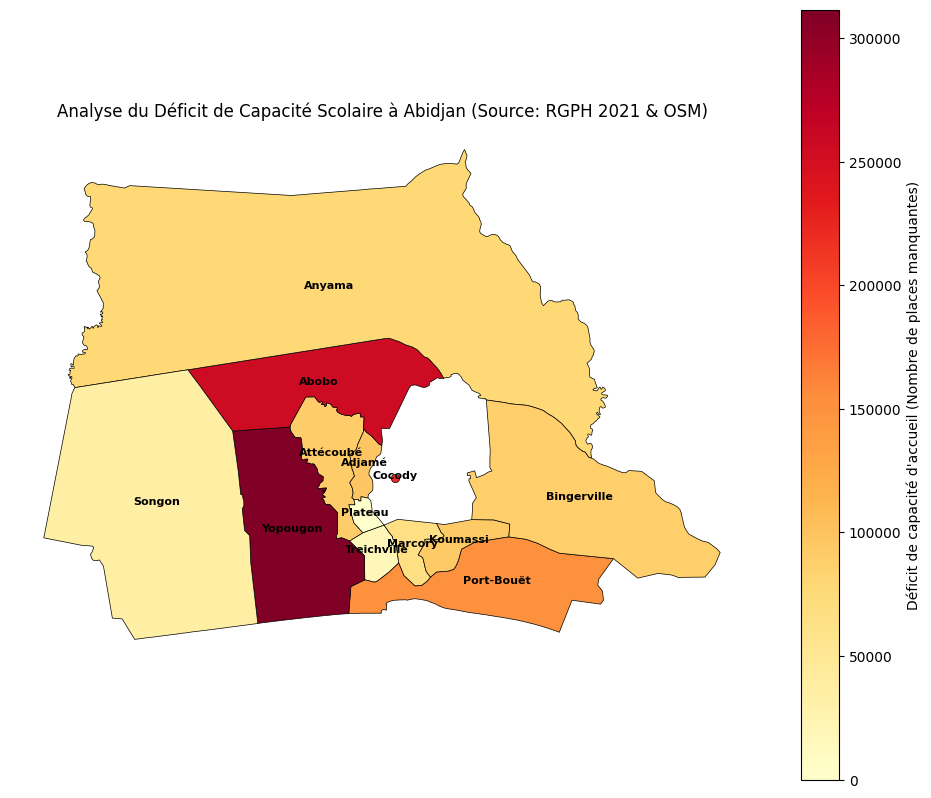

In [34]:
df_ecp['deficit_capacite'] = df_ecp['pop_scolaire_3_18'] - df_ecp['capacite_actuelle']
df_ecp['deficit_capacite'] = df_ecp['deficit_capacite'].clip(lower=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
df_ecp.plot(column='deficit_capacite', 
            cmap='YlOrRd', 
            legend=True, 
            legend_kwds={'label': "Déficit de capacité d'accueil (Nombre de places manquantes)"},
            ax=ax, 
            edgecolor='black', 
            linewidth=0.5)

for idx, row in df_ecp.iterrows():
    plt.annotate(text=row['name'], 
                 xy=row.geometry.centroid.coords[0], 
                 horizontalalignment='center', 
                 fontsize=8, 
                 fontweight='bold')

plt.title("Analyse du Déficit de Capacité Scolaire à Abidjan (Source: RGPH 2021 & OSM)")
plt.axis('off')
plt.show()

## INDICATEURS SPATIAUX

Pour prédire où construire des écoles, trois indicateurs GEE sont essentiels :

L'Indice de Bâti (BUILT-UP) : Via les données Dynamic World ou ESA WorldCover. Il permet de voir les zones qui se sont urbanisées entre 2015 et 2024.

In [35]:
# 1. Charger l'actif en tant qu'Image (et non ImageCollection)
# Le chemin correct pour la v200 est ee.Image("ESA/WorldCover/v200/2021")
worldcover = ee.Image("ESA/WorldCover/v200/2021")

ee_abidjan = geemap.gdf_to_ee(df_ecp)

# 2. Isoler les zones bâties (le code 50 représente l'urbain dans ESA)
built_up = worldcover.eq(50) 

# 3. Calculer les statistiques par commune
# Note : on utilise scale=10 car la résolution d'ESA WorldCover est de 10m
urban_stats = built_up.reduceRegions(
    collection=ee_abidjan,
    reducer=ee.Reducer.mean(),
    scale=10
)

# 4. Conversion finale
df_urban = geemap.ee_to_gdf(urban_stats)
df_ecp['taux_urbanisation'] = df_urban['mean']

c:\Users\olake\Desktop\PROJETS_CAS_ENTREPRISE\PROJET_2\venv_proj2\Lib\site-packages\pyogrio\raw.py:733: RuntimeWarning: NaN of Infinity value found. Skipped. Further messages of this type will be suppressed.
  ogr_write(


In [87]:
Map = geemap.Map(center=[5.3, -4.0], zoom=8)
Map.addLayer(built_up.selfMask(), {'palette': 'red'}, 'Zones Bâties 2021')
Map.add_gdf(ecoles, layer_name='Ecoles Actuelles')
Map.save('carte_ecoles_actuelles.html')

Les Lumières Nocturnes (Nighttime Lights) : Via VIIRS. C'est un excellent proxy de la richesse économique et de l'activité humaine.

In [37]:
# 1. Charger la collection VIIRS (Nighttime Day/Night Band)
# On prend une médiane sur l'année 2023 pour éviter les nuages et les lumières éphémères
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG") \
    .filterDate('2023-01-01', '2023-12-31') \
    .select('avg_rad') \
    .median()

# 2. Calculer l'intensité moyenne par commune
light_stats = viirs.reduceRegions(
    collection=ee_abidjan,
    reducer=ee.Reducer.mean(),
    scale=450 # La résolution de VIIRS est d'environ 450m-500m
)

# 3. Conversion et intégration au DataFrame
df_light = geemap.ee_to_gdf(light_stats)
df_ecp['intensite_lumineuse'] = df_light['mean']

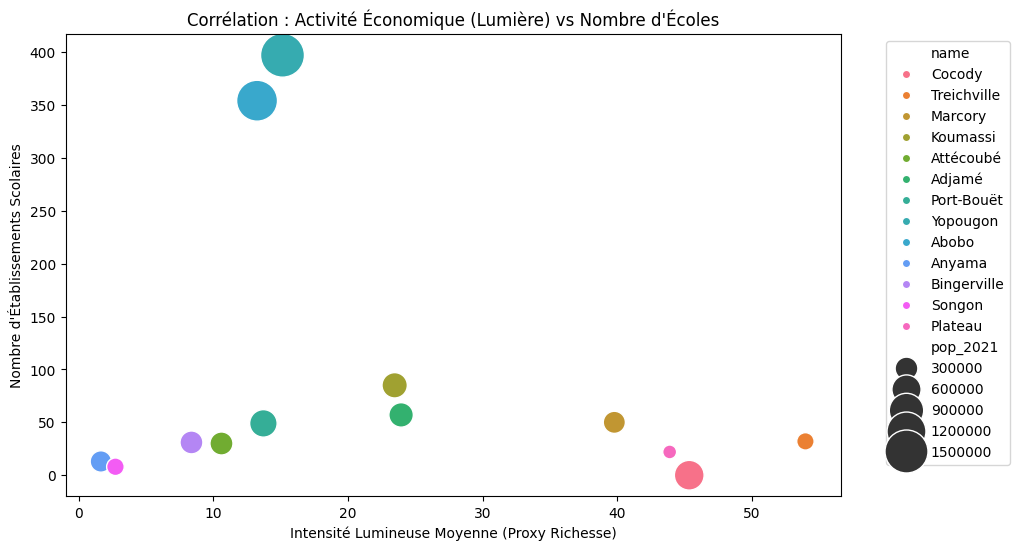

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_ecp, x='intensite_lumineuse', y='nb_ecoles', 
                size='pop_2021', hue='name', sizes=(100, 1000))

plt.title("Corrélation : Activité Économique (Lumière) vs Nombre d'Écoles")
plt.xlabel("Intensité Lumineuse Moyenne (Proxy Richesse)")
plt.ylabel("Nombre d'Établissements Scolaires")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Le NDVI (Indice de Végétation) : Pour repérer les zones de forêts qui sont en train d'être détruites pour de nouveaux lotissements (ex: à Songon).

In [ ]:
# Résolution spatiale raisonnable (compromis précision / performance)
SCALE = 30  

# Collection Sentinel-2 filtrée spatialement
s2 = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(ee_abidjan)
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
)

def compute_ndvi(image):
    return image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Composites annuels
ndvi_2019 = compute_ndvi(
    s2.filterDate('2019-01-01', '2019-12-31').median()
).clip(ee_abidjan)

ndvi_2024 = compute_ndvi(
    s2.filterDate('2024-01-01', '2024-12-31').median()
).clip(ee_abidjan)

# Réduction spatiale par commune
ndvi_2019_stats = ndvi_2019.reduceRegions(
    collection=ee_abidjan,
    reducer=ee.Reducer.mean(),
    scale=SCALE,
    tileScale=4
)

ndvi_2024_stats = ndvi_2024.reduceRegions(
    collection=ee_abidjan,
    reducer=ee.Reducer.mean(),
    scale=SCALE,
    tileScale=4
)

# Conversion vers GeoDataFrame
df_ndvi_2019 = geemap.ee_to_gdf(ndvi_2019_stats)
df_ndvi_2024 = geemap.ee_to_gdf(ndvi_2024_stats)

# Création de la vraie feature IA
df_ecp['ndvi_2019'] = df_ndvi_2019['mean']
df_ecp['ndvi_2024'] = df_ndvi_2024['mean']
df_ecp['delta_ndvi'] = df_ecp['ndvi_2024'] - df_ecp['ndvi_2019']

✅ NDVI 2019, NDVI 2024 et delta_ndvi calculés proprement.


## CLUSTERING TERRITORIAL BASE SUR LE DEFICIT DE CAPACITE SCOLAIRE, LA CROISSANCE DEMOGRAPHIQUE, LES INDICATEURS SPATIAUX

In [42]:
print(df_ecp.columns.tolist())

['name', 'geometry', 'bbox_west', 'bbox_south', 'bbox_east', 'bbox_north', 'place_id', 'osm_type', 'osm_id', 'lat', 'lon', 'class', 'type', 'place_rank', 'importance', 'addresstype', 'display_name', 'nb_ecoles', 'pop_2021', 'area_km2', 'densite_pop', 'capacite_actuelle', 'pop_scolaire_3_18', 'pop_maternelle', 'pop_primaire', 'pop_secondaire', 'taux_couverture', 'ratio_ecoles_1000_enfants', 'deficit_capacite', 'taux_urbanisation', 'intensite_lumineuse', 'ndvi_2019', 'ndvi_2024', 'delta_ndvi', 'score_priorite_final']


In [43]:
colonnes = [
    "name",
    "nb_ecoles",
    "pop_scolaire_3_18",
    "ratio_ecoles_1000_enfants",
    "deficit_capacite",
    "taux_urbanisation",
    "intensite_lumineuse",
    "delta_ndvi"
]

In [44]:
df_final = df_ecp[colonnes].copy()

In [45]:
df_final = df_final.rename(columns={
    "name": "commune"
})

In [46]:
df_final.isna().sum()

commune                      0
nb_ecoles                    0
pop_scolaire_3_18            0
ratio_ecoles_1000_enfants    0
deficit_capacite             0
taux_urbanisation            0
intensite_lumineuse          0
delta_ndvi                   0
dtype: int64

Aucune valeur manquante.

In [47]:
df_final.describe()

,nb_ecoles,pop_scolaire_3_18,ratio_ecoles_1000_enfants,deficit_capacite,taux_urbanisation,intensite_lumineuse,delta_ndvi
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,86.769231,167134.076923,0.373272,115895.538462,0.449005,22.758436,0.002616
std,130.392455,163655.792562,0.817550,94044.910063,0.294764,17.443978,0.033437
min,0.000000,2501.000000,0.000000,0.000000,0.040683,1.656667,-0.067135
25%,22.000000,86303.000000,0.095050,66193.000000,0.200022,10.608268,-0.007466
50%,32.000000,109060.000000,0.152840,91060.000000,0.485651,15.139847,0.009207
75%,57.000000,180431.000000,0.252695,151031.000000,0.608721,39.774252,0.012626
max,397.000000,549872.000000,3.077784,311672.000000,1.000000,53.960603,0.047584


In [48]:
from sklearn.preprocessing import StandardScaler    

communes = df_final['commune'].unique()
X = df_final.drop('commune', axis=1) 

Standardisation afin de rendre nos variables à la même échelle

In [49]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

Choix du nombre de clusters

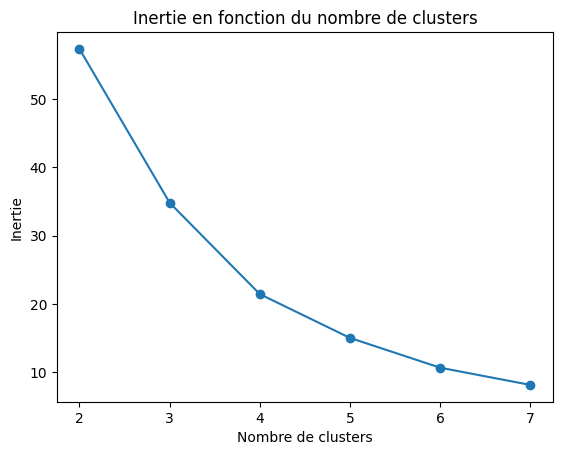

In [50]:
from sklearn.cluster import KMeans

inertie = []

for k in range(2,8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertie.append(km.inertia_)

plt.plot(range(2,8), inertie, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Inertie en fonction du nombre de clusters')
plt.show()

On constate avec le graphique que le nombre optimal de clusters est de 4.

Clustering

In [52]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_final['cluster'] = kmeans.fit_predict(X_scaled)
df_final.head()

,commune,nb_ecoles,pop_scolaire_3_18,ratio_ecoles_1000_enfants,deficit_capacite,taux_urbanisation,intensite_lumineuse,delta_ndvi,cluster
0,Cocody,0.0,220821,0.000000,220821.0,1.000000,45.334999,-0.003544,2
1,Treichville,32.0,37293,0.300323,18093.0,0.608721,53.960603,0.035795,2
2,Marcory,50.0,96193,0.181925,66193.0,0.649396,39.774252,0.011852,2
3,Koumassi,85.0,144271,0.206209,93271.0,0.491319,23.466895,0.043245,2
4,Attécoubé,30.0,109060,0.096277,91060.0,0.200022,10.608268,0.047584,0


In [81]:
df_final.head(13)

,commune,nb_ecoles,pop_scolaire_3_18,ratio_ecoles_1000_enfants,deficit_capacite,taux_urbanisation,intensite_lumineuse,delta_ndvi,cluster
0,Cocody,0.0,220821,inf,220821.0,1.000000,45.334999,-282.173161,2
1,Treichville,32.0,37293,3.329750,18093.0,0.608721,53.960603,27.937169,2
2,Marcory,50.0,96193,5.496760,66193.0,0.649396,39.774252,84.374427,2
3,Koumassi,85.0,144271,4.849459,93271.0,0.491319,23.466895,23.124288,2
4,Attécoubé,30.0,109060,10.386733,91060.0,0.200022,10.608268,21.015511,0
5,Adjamé,57.0,130528,6.542789,96328.0,0.849977,23.945017,110.821325,2
6,Port-Bouët,49.0,180431,10.520796,151031.0,0.333799,13.721431,-133.944987,0
7,Yopougon,397.0,549872,3.957343,311672.0,0.405997,15.139847,81.810714,1
8,Abobo,354.0,469029,3.785545,256629.0,0.485651,13.251674,-19.855709,1
9,Anyama,13.0,86303,18.967846,78503.0,0.040683,1.656667,-14.895434,0


In [56]:
profils_clusters = df_final.select_dtypes(include=['int64', 'float64']).groupby(df_final['cluster']).mean()
print(profils_clusters)

         nb_ecoles  pop_scolaire_3_18  ratio_ecoles_1000_enfants  \
cluster                                                            
0             26.2           104447.0                   0.083319   
1            375.5           509450.5                   0.258429   
2             44.8           125821.2                   0.168259   
3             22.0             2501.0                   3.077784   

         deficit_capacite  taux_urbanisation  intensite_lumineuse  delta_ndvi  
cluster                                                                        
0                 88727.0           0.154375             7.420849   -0.007369  
1                284150.5           0.445824            14.195760   -0.019070  
2                 98941.2           0.719883            37.296353    0.019274  
3                     0.0           0.574124            43.882139    0.012626  


* Le cluster 0 a peu d'écoles, une population scolaire élevée, un déficit de capacité important, un taux d'urbanisation faible, une intensité lumineuse très faible, la plus faible d'ailleurs et un NDVI négatif significatif. Aussi, le ratio écoles/population est très faible.

* Le cluster 1 a le plus grand nombre d'écoles, la population scolaire la plus élevée, un déficit de capacité très important, le plus important d'ailleurs, un taux d'urbanisation moyen, une intensité lumineuse modérée et un NDVI négatif significatif. Aussi, le ratio écoles/population est peu élevé.

* Le cluster 2 a un nombre d'écoles peu élevé et une population scolaire élevée, un déficit de capacité important, un taux d'urbanisation élevé,le plus élevé d'ailleurs, une intensité lumineuse très élevée, parmi les plus élevées et un NDVI positif significatif. Aussi, le ratio écoles/population est faible.

* Le cluster 3 a le plus petit nombre d'écoles, une population scolaire faible, un déficit de capacité nul, un taux d'urbanisation moyen, une intensité lumineuse très élevée, la plus élevée d'ailleurs et un NDVI positif significatif. Aussi, le ratio écoles/population est très élevé.

Interprétation métier des clusters

Cluster 0 -> Zones peu urbanisées sous-équipées en termes d'infrastructures scolaires
Ce sont des communes rurales ou peu urbanisées, avec une population scolaire élevée et un déficit de capacité important. L'activité économique y est faible.
Il faudrait construire plus d'écoles de base et concentrer les ressources publicques sur ces zones prioritaires.

Cluster 1 -> Zones urbaines saturées
Ce sont des communes urbaines où la pression démographique est bien supérieure à la capacité des écoles existantes.
Il faudrait améliorer les infrastructures existantes, les étendre et procéder à leur réhabilitation.

Cluster 2 -> Zones de forte croissance urbaine
Ce sont des communes urbaines où les territoires sont en pleine expansion urbaine et économique, où les besoins en écoles de base vont exploser à court ou moyen termes.
Il faudrait anticiper la demande en écoles de base et construire des écoles sur mesure tout en faisant une bonne planification.

Cluster 3 -> Zones bien équipées et stables
Ce sont des communes dotées en infrastructures scolaires et où la pression démographique est stable.
Il faudrait ici, se concentrer sur le maintien et le renforcement des infrastructures existantes, et donc concentrer les ressources allouées ici aux zones prioritaires telles que celles du cluster 0.

Identification des communes prioritaires

In [55]:
zones_prioritaires = df_final[df_final['cluster'] == 0].sort_values(by='deficit_capacite', ascending=False)
zones_prioritaires.head()

,commune,nb_ecoles,pop_scolaire_3_18,ratio_ecoles_1000_enfants,deficit_capacite,taux_urbanisation,intensite_lumineuse,delta_ndvi,cluster
6,Port-Bouët,49.0,180431,0.095050,151031.0,0.333799,13.721431,-0.007466,0
4,Attécoubé,30.0,109060,0.096277,91060.0,0.200022,10.608268,0.047584,0
10,Bingerville,31.0,107182,0.101229,88582.0,0.146193,8.380966,0.009207,0
9,Anyama,13.0,86303,0.052721,78503.0,0.040683,1.656667,-0.067135,0
11,Songon,8.0,39259,0.071320,34459.0,0.051180,2.736915,-0.019035,0


### Calcul du score de priorité
Il s'agit d'un score unique allant de 0 à 100 qui permettra de classer les communes par ordre de priorité d'intervention scolaire, justifier les décisions d'investissement.

On prendra en compte les critères suivants :
- le déficit de capacité scolaire
- le ratio de population par établissement scolaire
- le taux d'urbanisation
- l'intensité lumineuse
- le NDVI.

Chaque critère sera pondéré et normalisé pour éviter les biais d'échelle et donc permettre une comparaison entre les communes.

Normalisation

In [67]:
from sklearn.preprocessing import MinMaxScaler

variables_score = [
    'deficit_capacite',
    'ratio_ecoles_1000_enfants',
    'taux_urbanisation',
    'intensite_lumineuse',
    'delta_ndvi']

scaler = MinMaxScaler()

df_score = df_final[["commune", "cluster"] + variables_score].copy()

df_score[variables_score] = df_score[variables_score].fillna(0)

In [74]:
for c in variables_score:
    df_score.loc[np.isinf(df_score[c]), c] = np.nan
    df_score[c] = df_score[c].fillna(df_score[c].median())

In [75]:
df_score[variables_score] = scaler.fit_transform(df_score[variables_score])

On inverse les valeurs positives, c'est-à-dire que les variables qui réduisent la priorité lorsqu'elles sont plus grandes seront pondérées moins (ratio_ecoles_1000_enfants et delta_ndvi).

In [76]:
df_score['ratio_ecoles_1000_enfants'] = 1 - df_score['ratio_ecoles_1000_enfants']
df_score['delta_ndvi'] = 1 - df_score['delta_ndvi']

Pondération métier

In [77]:
df_score["score_priorite"] = ( 
    0.40 * df_score["deficit_capacite"] +
    0.20 * df_score["ratio_ecoles_1000_enfants"] +
    0.15 * df_score["taux_urbanisation"] +
    0.15 * df_score["intensite_lumineuse"] +
    0.10 * df_score["delta_ndvi"]
) * 100

Classement final

In [80]:
df_score = df_score.sort_values(by="score_priorite", ascending=False)
df_score[["commune", "cluster", "score_priorite"]].head(13)

,commune,cluster,score_priorite
0,Cocody,2,79.757073
7,Yopougon,1,66.420217
8,Abobo,1,62.831245
1,Treichville,2,45.089438
5,Adjamé,2,44.738432
2,Marcory,2,44.069325
6,Port-Bouët,0,42.716680
3,Koumassi,2,42.649068
12,Plateau,3,41.255175
4,Attécoubé,0,28.236198


En fin de compte, la priorité est critique à Cocody, élevée à Yopougon et Abobo, modérée à Treichville, Adjamé, Marcory, Port-Bouët, Koumassi et Plateau, et faible à Attécoubé, Bingerville, Songon et Anyama.

Carte des priorités

In [ ]:
df_merged = df_ecp.merge(df_score, left_on="name", right_on="commune")

In [84]:
df_merged.head()

,name,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,...,delta_ndvi_x,score_priorite_final,commune,cluster,deficit_capacite_y,ratio_ecoles_1000_enfants_y,taux_urbanisation_y,intensite_lumineuse_y,delta_ndvi_y,score_priorite
0,Cocody,POINT (-3.99493 5.35737),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.003544,-0.025602,Cocody,2,0.708504,0.694530,1.000000,0.835087,1.000000,79.757073
1,Treichville,"POLYGON ((-4.03362 5.30429, -4.02226 5.31133, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.035795,0.017563,Treichville,2,0.058051,0.838821,0.592127,1.000000,0.210904,45.089438
2,Marcory,"POLYGON ((-4.00415 5.31786, -3.99241 5.32272, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.011852,-0.013108,Marcory,2,0.212380,0.722584,0.634527,0.728771,0.067296,44.069325
3,Koumassi,"POLYGON ((-3.96459 5.27353, -3.96493 5.27412, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.043245,0.000838,Koumassi,2,0.299260,0.757305,0.469747,0.416990,0.223151,42.649068
4,Attécoubé,"POLYGON ((-4.08424 5.40104, -4.08417 5.40162, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.047584,-0.046586,Attécoubé,0,0.292166,0.460288,0.166096,0.171146,0.228517,28.236198


In [85]:
df_merged = df_merged[["name","geometry","cluster","score_priorite"]]

In [ ]:
mc = folium.Map(location=[5.35, -4.02], zoom_start=7)

colors = { 0: 'blue', 1: 'green', 2: 'red', 3: 'purple'}

# Création de la légende
legend_html = "<div style='position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white; padding: 10px; border: 1px solid black;'></div>"
for cluster, color in colors.items():
    legend_html += f"<div style='background-color: {color}; width: 20px; height: 20px; display: inline-block; margin-right: 5px;'></div>Cluster {cluster}<br>"
mc.get_root().html.add_child(folium.Element(legend_html))



for _, row in df_merged.iterrows():
    geo_json = folium.GeoJson(
        row["geometry"].__geo_interface__,
        style_function=lambda feature, cluster = row['cluster']:{'fillColor': colors[cluster], 'color': 'black', 'weight': 1, 'fillOpacity': 0.5})
    folium.Popup(f"{row['name']} - Cluster{row['cluster']} - Score{row['score_priorite']}").add_to(geo_json)
    geo_json.add_to(mc)
mc.save("carte_priorite.html")